# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

Given the set of features describing individual car and the target price value, model the feature influence on the price estimation.

Use the model to identify how each feature contributes to the price and highlight business-relevant features to consider when filling up the dealership lot.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from collections import Counter

def condition_rank(v):
    return {'new': 5, 'like new': 4, 'excellent': 3, 'good': 2, 'fair': 1, 'salvage': 0, 'nan': -1}[str(v)]

def drive_rank(v):
    return {'4wd': 4, 'rwd': 2, 'fwd': 1, 'nan': -1}[str(v)]

def type_rank(v):
    return {'nan': -1, 'other': 0, 'coupe': 1, 'hatchback': 2, 'convertible': 3, 'sedan': 4, 'wagon': 5, 'SUV': 6, 'offroad': 7, 'mini-van': 8, 'pickup': 9, 'truck': 10, 'van': 11, 'bus': 12}[str(v)]

def fuel_rank(v):
    return {'nan': -1, 'other': 0, 'gas': 1, 'diesel': 2, 'hybrid': 3, 'electric': 4}[str(v)]

In [2]:
df = pd.read_csv('data/vehicles.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [4]:
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [5]:
df.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


##### Check the data availability

[Text(0, 0, '91.8319'), Text(0, 0, '8.1681')]

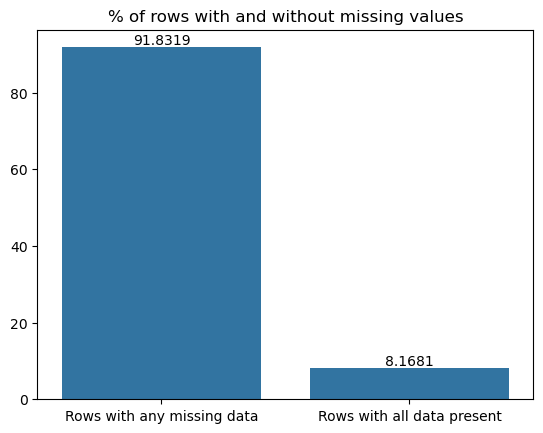

In [6]:
rows_with_missing = df.isna().any(axis=1).sum() / len(df) * 100
rows_without_missing = 100 - rows_with_missing
combined_missing_data = pd.Series({'Rows with any missing data': rows_with_missing, 'Rows with all data present': rows_without_missing})
ax = sns.barplot(combined_missing_data)
ax.set_title('% of rows with and without missing values')
ax.bar_label(ax.containers[0])

The state representation shows that if we were to seek any state-specific correlations, we may not have enough data for some states. Thus the model may become biased toward California and maybe Florida market.

Text(0.5, 1.0, 'Data distribution among states')

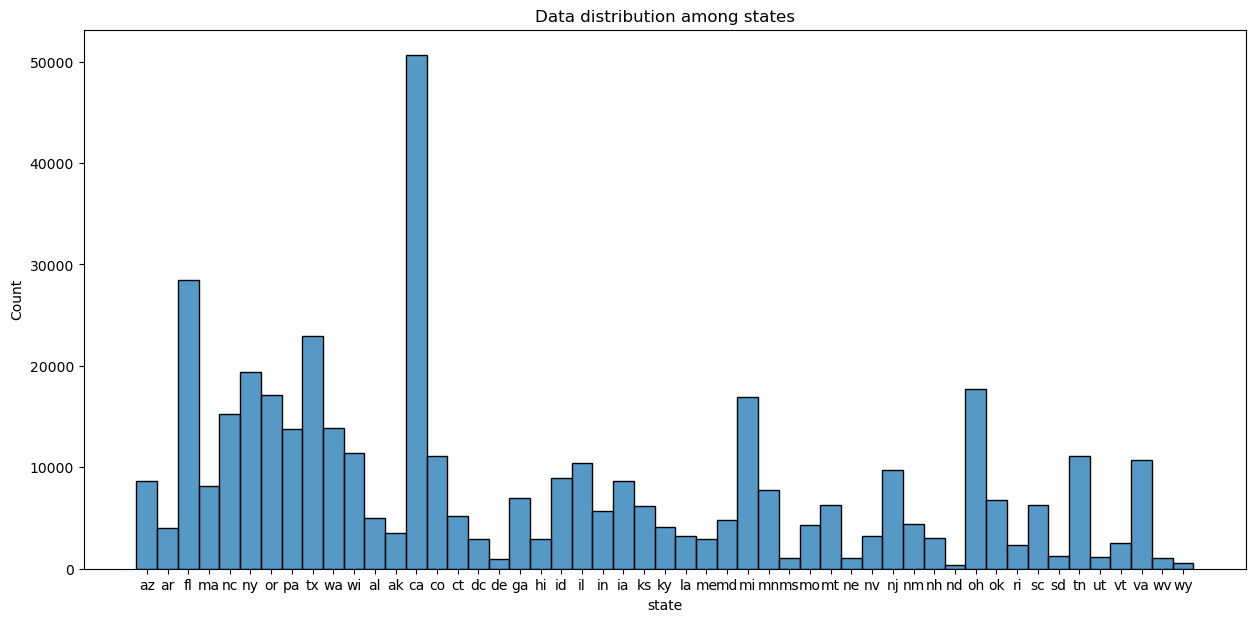

In [7]:
plt.figure(figsize=(15,7))
ax = sns.histplot(df, x='state')
ax.set_title('Data distribution among states')

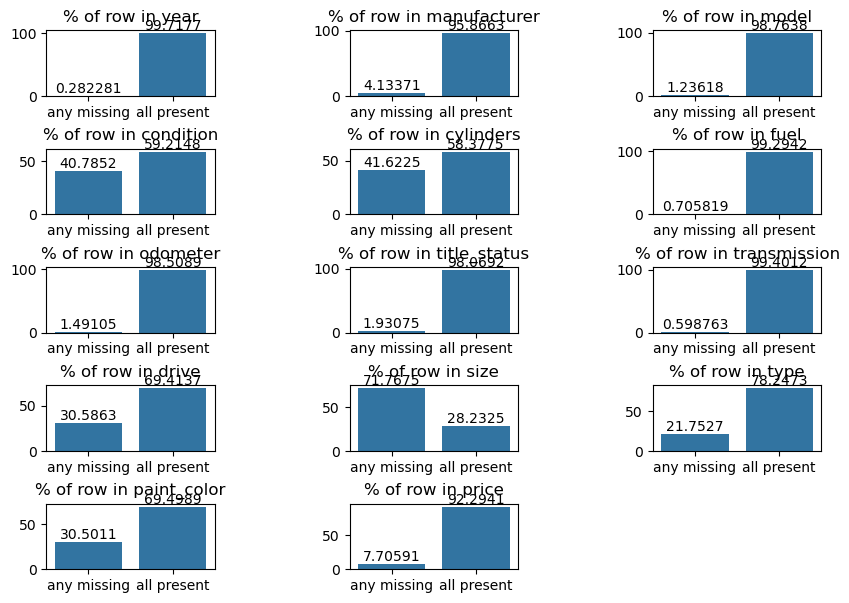

In [8]:
cols = ['year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'price']

fig=plt.figure(figsize=(10,7))
fig.subplots_adjust(wspace=0.8, hspace=0.8)
ncols = 3
nrows = -(-len(cols) // 3)
for i, col in enumerate(cols):
    col_df = df[[col]]
    rows_with_missing = (col_df.isna().any(axis=1).sum() + (col_df[col] == 0).sum()) / len(df) * 100.0
    rows_without_missing = 100.0 - rows_with_missing
    combined_missing_data = pd.DataFrame([{'title': 'any missing', 'value': rows_with_missing}, {'title': 'all present', 'value': rows_without_missing}])
    fig.add_subplot(nrows, ncols, i + 1)
    ax = sns.barplot(combined_missing_data, x='title', y='value')
    ax.set_title('% of row in ' + col)
    ax.set_xlabel(None)
    ax.set_ylabel('')
    ax.bar_label(ax.containers[0])
plt.show()

We observe that 1/3 of color data, 1/3 of drive data, almost 1/2 of condition and cylinders data, and 2/3 of size data are missing.
They may not be sufficient to be used in modeling.

The cylinders, drive and size data may be substituted by the known manufacturer and model.
The color and condition cannot be referenced by any other source.

Next chart confirms the hypothesis that even with high rates of missing data, it is reconstructable by referencing manufacturer and model.

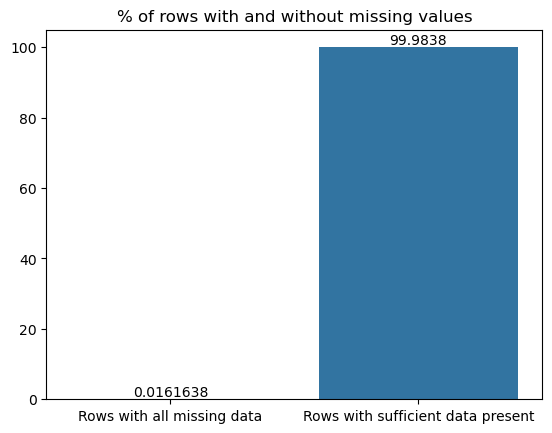

In [96]:
check_df = df[['cylinders', 'manufacturer', 'model', 'drive', 'size']]
rows_with_no_reference = check_df.isna().all(axis=1).sum() / len(check_df) * 100.0
sufficient_rows = 100.0 - rows_with_no_reference
combined_missing_data = pd.Series({'Rows with all missing data': rows_with_no_reference, 'Rows with sufficient data present': sufficient_rows})
ax = sns.barplot(combined_missing_data)
ax.set_title('% of rows with and without missing values')
ax.bar_label(ax.containers[0])
plt.savefig('images/backfill_success_rate.png')

Verifying that there is consistency in manufacturer+model feature definitions

In [10]:
check_df = df[['cylinders', 'manufacturer', 'model', 'drive', 'size']]
unique_df = check_df.groupby(['manufacturer', 'model']).nunique()
print("Number of manufacturer models with ambiguous features: " + str(len(unique_df[(unique_df['cylinders'] > 1) | (unique_df['drive'] > 1) | (unique_df['size'] > 1)])))
print("Number of manufacturer models: " + str(len(unique_df)))

Number of manufacturer models with ambiguous features: 4222
Number of manufacturer models: 24167


In [11]:
target_models_df = unique_df[(unique_df['cylinders'] > 1) | (unique_df['drive'] > 1) | (unique_df['size'] > 1)].reset_index()[['manufacturer', 'model']]
narrow_df = df[['cylinders', 'manufacturer', 'model', 'drive', 'size']]
# leave only rows with problematic manufacturer and model
check_df = narrow_df[pd.Series(list(zip(narrow_df.manufacturer.values, narrow_df.model.values))).isin(list(zip(target_models_df.manufacturer.values, target_models_df.model.values)))]
# python dicts
groups = {}
for i, r in check_df.iterrows():
    if r['manufacturer'] not in groups:
        groups[r['manufacturer']] = {}
    if r['model'] not in groups[r['manufacturer']]:
        groups[r['manufacturer']][r['model']] = ({}, Counter())
    key = str(r['cylinders']) + ' _ ' + str(r['drive']) + ' _ ' + str(r['size'])
    groups[r['manufacturer']][r['model']][0][key] = (r['cylinders'], r['drive'], r['size'])
    groups[r['manufacturer']][r['model']][1].update([key])
# select most common feature set
v = []
for mf, g in groups.items():
    for md, r in g.items():
        feature_key = r[1].most_common(1)[0][0]
        f = r[0][feature_key]
        v.append({'manufacturer': mf, 'model': md, 'cylinders': f[0], 'drive': f[1], 'size': f[2]})
final_feature_df = pd.DataFrame(v).dropna()
final_feature_df

,manufacturer,model,cylinders,drive,size
0,chevrolet,silverado 1500,8 cylinders,4wd,full-size
9,chevrolet,express cargo van,8 cylinders,rwd,full-size
15,chevrolet,tahoe,8 cylinders,4wd,full-size
29,chevrolet,silverado 2500hd,8 cylinders,4wd,full-size
35,chevrolet,silverado z71 4x4,8 cylinders,4wd,full-size
...,...,...,...,...,...
4211,mercury,milan hybrid,4 cylinders,fwd,mid-size
4212,mercury,sable ls premium,6 cylinders,fwd,mid-size
4215,alfa-romeo,romeo spider,4 cylinders,rwd,mid-size
4217,alfa-romeo,romeo stelvio,4 cylinders,4wd,mid-size


Lastly, observe the price series per state. Besides the dip in Oregon prices and obvious outliers at higher prices, majority of price data looks similar across all states.

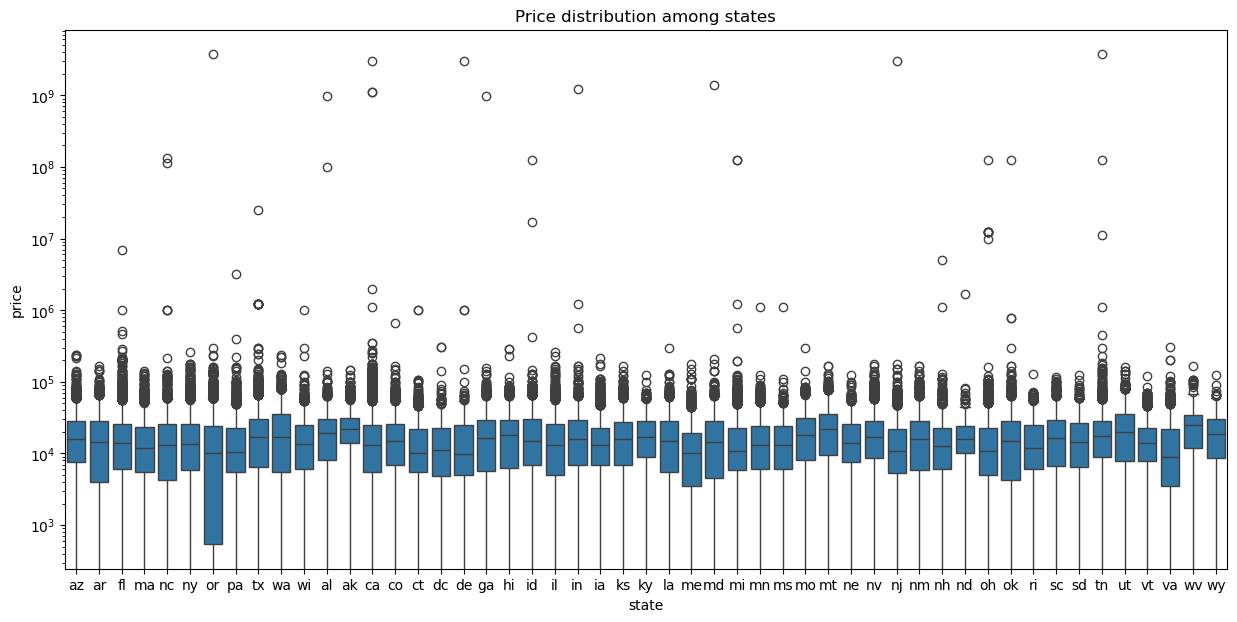

In [95]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(df[['price', 'state']], x="state", y="price")
ax.set_yscale("log")
ax.set_title('Price distribution among states')
plt.savefig('images/per_state_prices.png')

There are both outliers near 0 and at billion scale. In real world, most expensive car ever sold is \\$142 million which contradicts given billions values in the dataset. And for the purpose of modeling the car price, all those near \\$0 sales give no signal either.

In [13]:
df[df['price'] > 142_000_000]

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
280,7315849335,birmingham,987654321,1960.0,chevrolet,NaN,NaN,NaN,gas,999999.0,clean,manual,NaN,NaN,NaN,NaN,NaN,al
29386,7305265540,humboldt county,1111111111,1999.0,ford,f350 super duty lariat,good,8 cylinders,diesel,149000.0,clean,automatic,NaN,rwd,full-size,pickup,white,ca
37409,7314053169,modesto,1111111111,2020.0,jeep,NaN,NaN,NaN,gas,1000.0,clean,automatic,NaN,4wd,NaN,NaN,NaN,ca
37410,7314052904,modesto,3009548743,2021.0,chevrolet,NaN,NaN,8 cylinders,gas,1000.0,clean,automatic,NaN,4wd,NaN,NaN,NaN,ca
91576,7309730903,delaware,3024942282,2000.0,mercedes-benz,benz e320,NaN,NaN,gas,100000.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,de
122470,7315836487,atlanta,987654321,1960.0,chevrolet,NaN,NaN,NaN,gas,9999999.0,clean,manual,NaN,NaN,NaN,NaN,NaN,ga
153082,7305153975,indianapolis,1234567890,2006.0,volvo,vnl,fair,NaN,other,200000.0,clean,manual,NaN,NaN,NaN,NaN,black,in
184704,7304345156,frederick,1410065407,1989.0,jeep,wrangler,NaN,NaN,diesel,103000.0,clean,manual,NaN,NaN,NaN,SUV,NaN,md
257840,7309735768,south jersey,3024942282,2000.0,mercedes-benz,benz s430,NaN,NaN,gas,100000.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,nj
318592,7308056031,eugene,3736928711,2007.0,toyota,tundra,excellent,8 cylinders,gas,164000.0,clean,automatic,NaN,4wd,full-size,pickup,silver,or


Text(0.5, 1.0, 'Price distribution in data for \\$0-\\$1000')

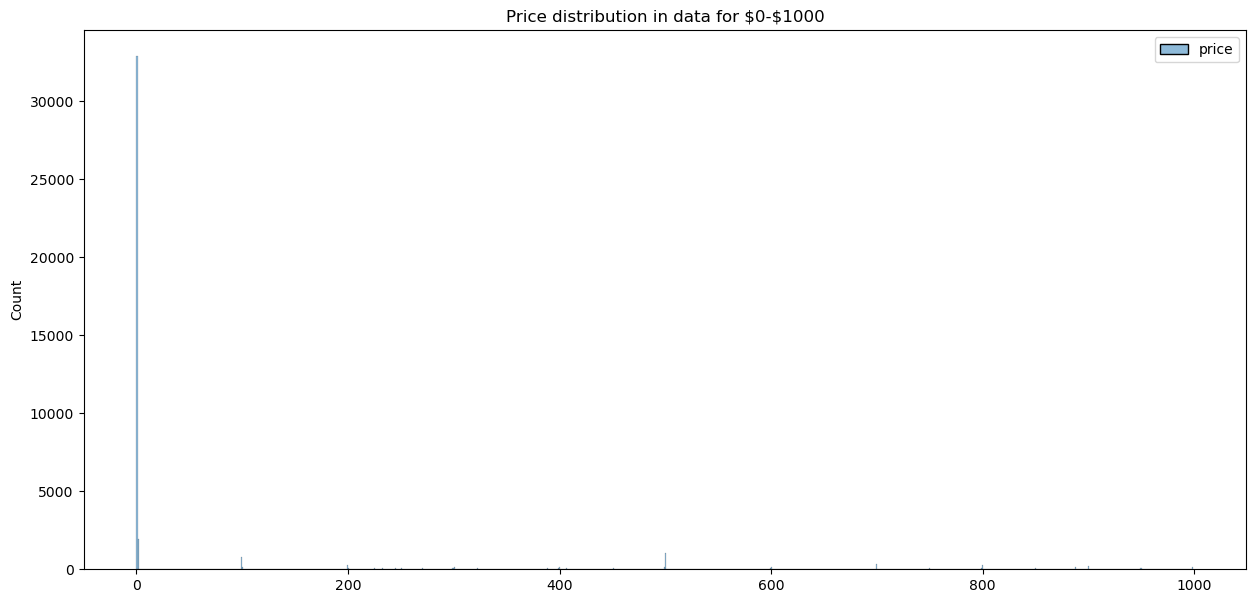

In [14]:
plt.figure(figsize=(15,7))
ax = sns.histplot(df[df['price'] < 1000][['price']], bins=1000)
ax.set_title('Price distribution in data for \\$0-\\$1000')

In [15]:
df[df['price'] < 100]

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
10,7218893038,el paso,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx
11,7218325704,el paso,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx
12,7217788283,el paso,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx
13,7217147606,el paso,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx
14,7209027818,el paso,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426764,7303347225,wyoming,0,2018.0,NaN,peterbilt 579,NaN,NaN,diesel,1.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,wy
426812,7302877815,wyoming,0,2006.0,toyota,scion tc,excellent,4 cylinders,gas,195000.0,clean,automatic,JTKDE177460109655,fwd,NaN,NaN,silver,wy
426832,7302353283,wyoming,0,2004.0,toyota,prius,excellent,4 cylinders,hybrid,239000.0,clean,automatic,JTDKB20U840108051,fwd,NaN,NaN,blue,wy
426836,7302301268,wyoming,0,2018.0,ram,2500,excellent,6 cylinders,diesel,20492.0,clean,automatic,3C6UR5HL3JG307217,4wd,full-size,truck,white,wy


In [16]:
Q1 = df['price'].quantile(0.1)
Q3 = df['price'].quantile(0.9)
IQR = Q3 - Q1
lower_bound = Q1 # to not go into negatives
upper_bound = Q3 + 1.5 * IQR
{'P90 upper price': Q3, 'P90 lower price': Q1, 'Lower outlier cutoff': lower_bound, 'Upper outlier cutoff': upper_bound}

{'P90 upper price': np.float64(37590.0),
 'P90 lower price': np.float64(500.0),
 'Lower outlier cutoff': np.float64(500.0),
 'Upper outlier cutoff': np.float64(93225.0)}

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

First, limit the price range

In [17]:
limited_price_df = df[(df['price'] > lower_bound) & (df['price'] < upper_bound)]
"Dropped " + str(len(df) - len(limited_price_df))

'Dropped 43989'

Fix the cylinders to be numeric

In [18]:
from itertools import takewhile
import math
numbered_df = limited_price_df.fillna(final_feature_df)
numbered_df['cylinders'] = numbered_df.apply(lambda r: (0.5 if r['cylinders'] == 'other' else int(''.join(takewhile(str.isdigit, str(r['cylinders']))))) if pd.notnull(r['cylinders']) else r['cylinders'], axis=1)

Next, remove rows with incomplete data

In [19]:
removed_clear_na_df = numbered_df
for col in ['year', 'odometer', 'cylinders']:
    removed_clear_na_df = removed_clear_na_df[removed_clear_na_df[col] > 0]
for col in ['fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color']:
    removed_clear_na_df = removed_clear_na_df[~removed_clear_na_df[col].isna()]
"Dropped " + str(len(numbered_df) - len(removed_clear_na_df))

'Dropped 292432'

Next, convert year of manufacturing into the age of the car

In [20]:
from datetime import datetime

current_year = datetime.now().year
# replace year with age
removed_clear_na_df['age'] = current_year - removed_clear_na_df['year']

Next, remove unnecessary columns

In [21]:
final_clean_df = removed_clear_na_df.drop(['VIN', 'manufacturer', 'model', 'year'], axis=1)

Next, normalize/scale values in odometer and price. Both are mapped to a range 0-10

In [35]:
normalized_df = final_clean_df.copy()
price_scaling_mean = 0 # not centering data at the mean
price_scaling_std = normalized_df['price'].max()
odometer_scaling_mean = 0 # not centering data at the mean
odometer_scaling_std = normalized_df['odometer'].max()
normalized_df['price'] = (normalized_df['price'] - price_scaling_mean) / price_scaling_std
normalized_df['odometer'] = (normalized_df['odometer'] - odometer_scaling_mean) / odometer_scaling_std

Next is to deal with categorical data, by creating one-hot for all av

In [36]:
final_prepare_df = pd.get_dummies(normalized_df, columns=['condition', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color'])
print("Added columns " + str(len(final_prepare_df.columns) - len(normalized_df.columns)))
final_prepare_df

Added columns 44


,id,region,price,cylinders,odometer,state,age,condition_excellent,condition_fair,condition_good,...,paint_color_brown,paint_color_custom,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow
29,7316814989,auburn,0.430326,8.0,0.001916,al,5.0,False,False,True,...,False,False,False,False,False,False,True,False,False,False
31,7316356412,auburn,0.163043,6.0,0.012800,al,12.0,True,False,False,...,False,False,False,False,False,False,False,False,False,False
35,7316257769,auburn,0.325978,6.0,0.001730,al,9.0,False,False,True,...,False,False,False,False,False,False,True,False,False,False
38,7315816316,auburn,0.358587,6.0,0.003004,al,8.0,False,False,True,...,False,False,False,False,False,False,False,True,False,False
40,7315756348,auburn,0.336848,8.0,0.003494,al,9.0,False,False,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426808,7302963673,wyoming,0.195652,8.0,0.013000,wy,20.0,True,False,False,...,False,False,False,False,False,False,False,False,False,False
426809,7302963273,wyoming,0.195652,8.0,0.011440,wy,35.0,False,False,True,...,False,False,False,False,False,False,False,False,False,False
426831,7302384818,wyoming,0.106522,6.0,0.011500,wy,40.0,False,False,False,...,False,False,False,False,False,False,True,False,False,False
426833,7302338378,wyoming,0.073913,8.0,0.006955,wy,28.0,False,False,True,...,False,False,False,False,False,False,False,False,True,False


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [37]:
X = final_prepare_df.drop(['price', 'region', 'state', 'id'], axis=1)
y = final_prepare_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 23)

First, check linear models

In [60]:
lasso_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('lasso', Lasso(random_state=23, alpha=0.01))])
lasso_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.01, random_state=23))])

In [40]:
linear_pipe = Pipeline(steps=[
    ('selector', SequentialFeatureSelector(LinearRegression(), n_features_to_select=6)),
    ('linear', LinearRegression())])
linear_pipe.fit(X_train, y_train)

Pipeline(steps=[('selector',
                 SequentialFeatureSelector(estimator=LinearRegression(),
                                           n_features_to_select=6)),
                ('linear', LinearRegression())])

Next, check polynomials

In [56]:
p_lasso_pipe = Pipeline(steps=[
    ('features', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('lasso', Lasso(random_state=23, alpha=0.01))])
p_lasso_pipe.fit(X_train, y_train)

Pipeline(steps=[('features', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.01, random_state=23))])

In [68]:
#p_linear_pipe = Pipeline(steps=[
#    ('features', PolynomialFeatures(degree=2, include_bias=False)),
#    ('selector', SequentialFeatureSelector(LinearRegression(), n_features_to_select=6)),
#    ('linear', LinearRegression())])
#p_linear_pipe.fit(X_train, y_train)

Linear regression with polynomials of power 2 is already taking excessive computational resources for SequentialFeatureSelector. Excluding it from model selection.

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

Checking the mean squared error of each model

In [66]:
lasso_train_error = mean_squared_error(y_train, lasso_pipe.predict(X_train))
lasso_test_error = mean_squared_error(y_test, lasso_pipe.predict(X_test))
linear_train_error = mean_squared_error(y_train, linear_pipe.predict(X_train))
linear_test_error = mean_squared_error(y_test, linear_pipe.predict(X_test))
p_lasso_train_error = mean_squared_error(y_train, p_lasso_pipe.predict(X_train))
p_lasso_test_error = mean_squared_error(y_test, p_lasso_pipe.predict(X_test))
errors = {"Lasso Polynomial 1": (lasso_train_error, lasso_test_error),
          "Lasso Polynomial 2": (p_lasso_train_error, p_lasso_test_error),
          "Linear Polynomial 1": (linear_train_error, linear_test_error)}
dict(sorted(errors.items(), key=lambda item: item[1]))

{'Lasso Polynomial 2': (0.009950450943773035, 0.010202039821646703),
 'Lasso Polynomial 1': (0.011289676362635268, 0.01139545279809923),
 'Linear Polynomial 1': (0.011292655305640352, 0.011310564610698206)}

LASSO degree 1 produced the worst model according to test data. Linear Polynomial degree 1 was next. LASSO degree 2 produced the best model.

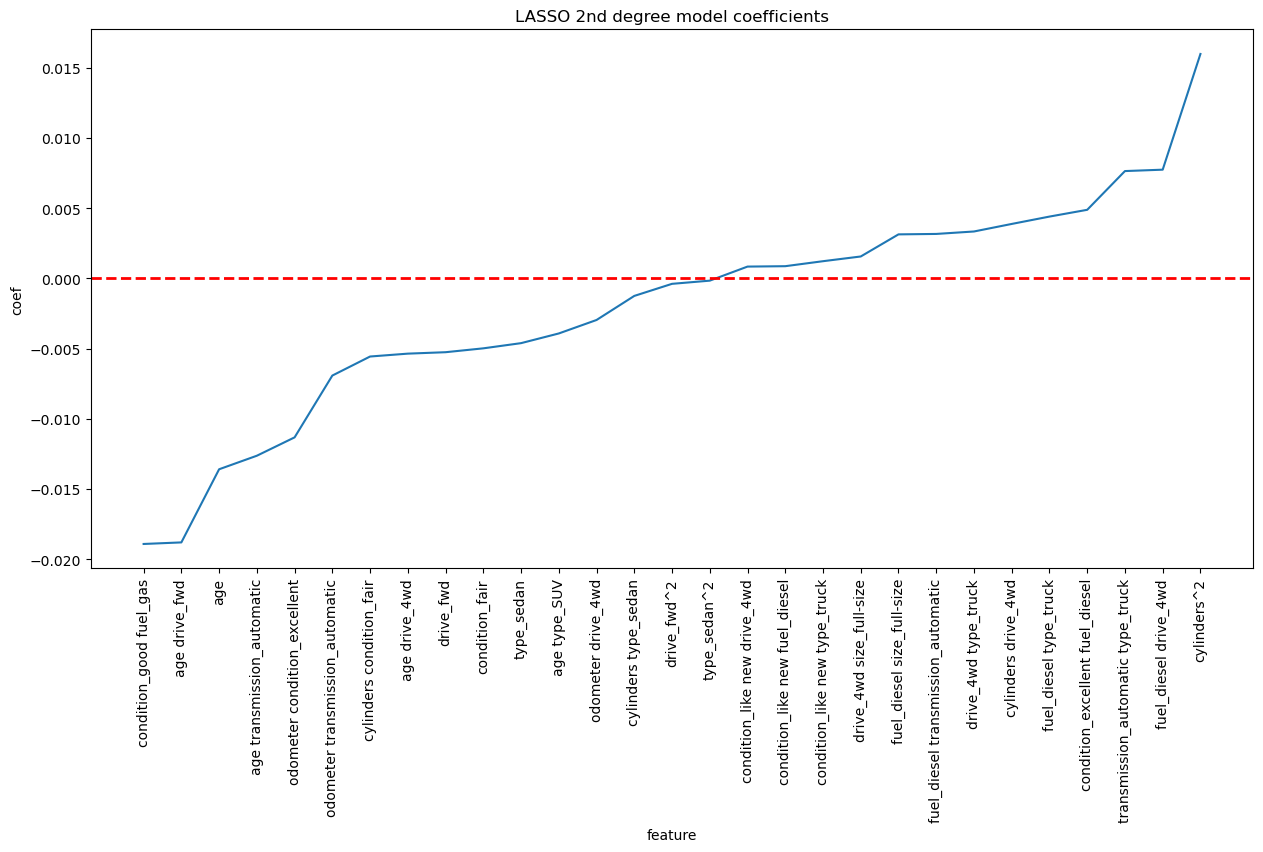

In [100]:
feature_names = p_lasso_pipe.named_steps['features'].get_feature_names_out()
p_lasso_df = pd.DataFrame(zip(feature_names, p_lasso_pipe.named_steps['lasso'].coef_), columns=['feature', 'coef'])
plt.figure(figsize=(15,7))
ax = sns.lineplot(p_lasso_df.loc[p_lasso_df['coef'] != 0].sort_values('coef'), x='feature', y='coef')
ax.set_title('LASSO 2nd degree model coefficients')
ax.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax.tick_params(axis='x', rotation=90)
plt.savefig('images/model_coef.png', bbox_inches='tight')

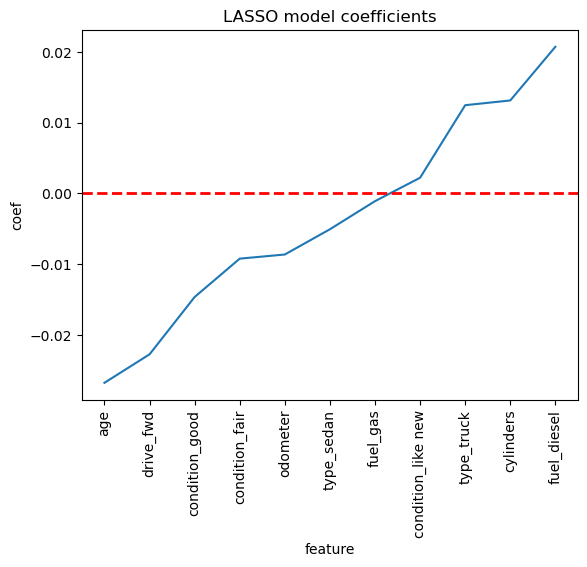

In [80]:
feature_names = X_train.columns
lasso_df = pd.DataFrame(zip(feature_names, lasso_pipe.named_steps['lasso'].coef_), columns=['feature', 'coef'])
ax = sns.lineplot(lasso_df.loc[lasso_df['coef'] != 0].sort_values('coef'), x='feature', y='coef')
ax.set_title('LASSO model coefficients')
ax.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax.tick_params(axis='x', rotation=90)

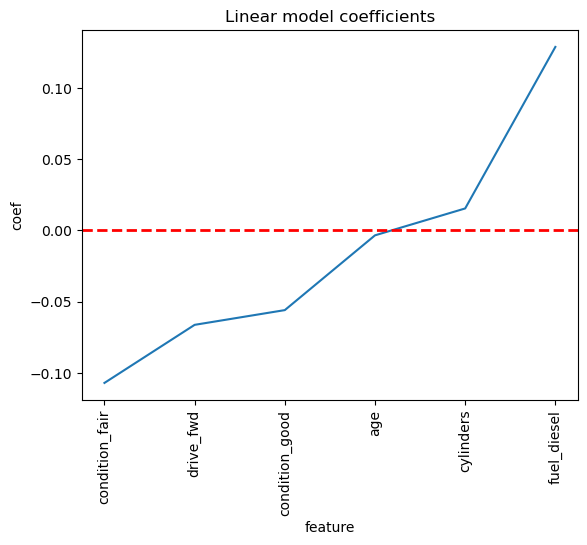

In [79]:
feature_names = linear_pipe.named_steps['selector'].get_feature_names_out()
linear_df = pd.DataFrame(zip(feature_names, linear_pipe.named_steps['linear'].coef_), columns=['feature', 'coef'])
ax = sns.lineplot(linear_df.loc[linear_df['coef'] != 0].sort_values('coef'), x='feature', y='coef')
ax.set_title('Linear model coefficients')
ax.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax.tick_params(axis='x', rotation=90)

If we were to interpret the coefficients of the models as penalties or benefits when estimating the used car price, then LASSO and Linear regression chose slightly different criteria.

Linear regression improves the car value if **condition is new** with a **diesel engine**. Linear regression lowers the car value for a **old**, **good or fair condition** or only **forward-wheel-drive**.

LASSO positively prefers **new condition**, **truck** with **more cylinders**, and again **diesel engine**. LASSO also negatively rejects **forward-wheel-drive**, **good or fair condition**, **high mileage** and specifically **sedans**, obviously highlighting as well the **age of the car** as most impactful.

LASSO with 2nd degree uncovered more feature interactions and received better fit, but from the feature point of view, we can see some similar highlights. For example, **number of cylinders** is squared to have higher positive impact. Negative feedback is exaggerated for **sedans** and **forward-wheel-drive**. This model points out the **diesel all-wheel-drive truck** as a highly positive combination.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

Text(0.5, 1.0, 'Preference of cars by condition. Newer - better and salvage - much worse')

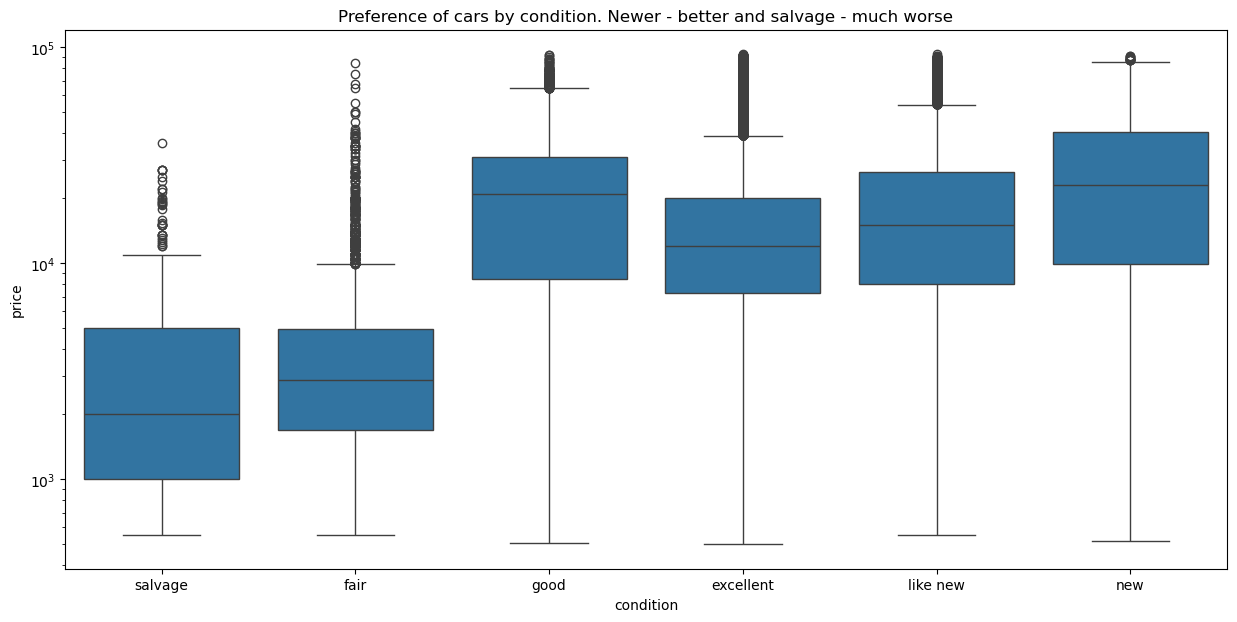

In [69]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(limited_price_df[['price', 'condition']].sort_values('condition', key=lambda v: v.apply(condition_rank)), x="condition", y="price")
ax.set_yscale("log")
ax.set_title('Preference of cars by condition. Newer - better and salvage - much worse')

Text(0.5, 1.0, 'Preference of cars by power train. 4-wheel-drive - better and forward-wheel-drive - much worse')

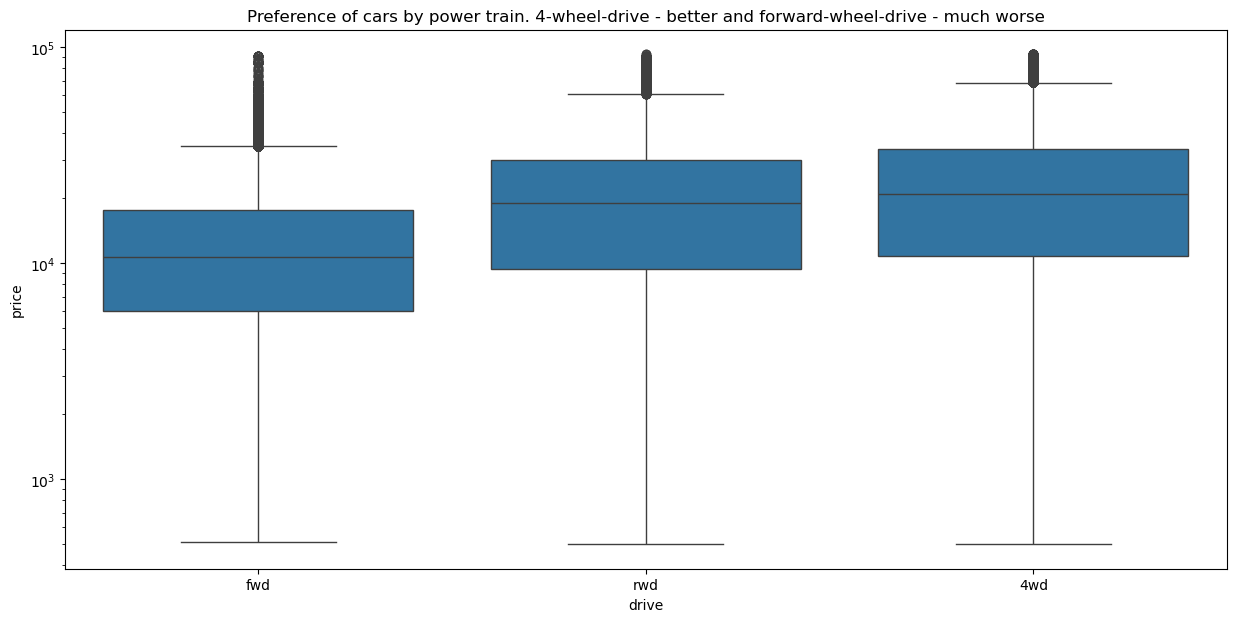

In [70]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(limited_price_df[['price', 'drive']].sort_values('drive', key=lambda v: v.apply(drive_rank)), x="drive", y="price")
ax.set_yscale("log")
ax.set_title('Preference of cars by power train. 4-wheel-drive - better and forward-wheel-drive - much worse')

Text(0.5, 1.0, 'Preference of cars by type. Truck - better')

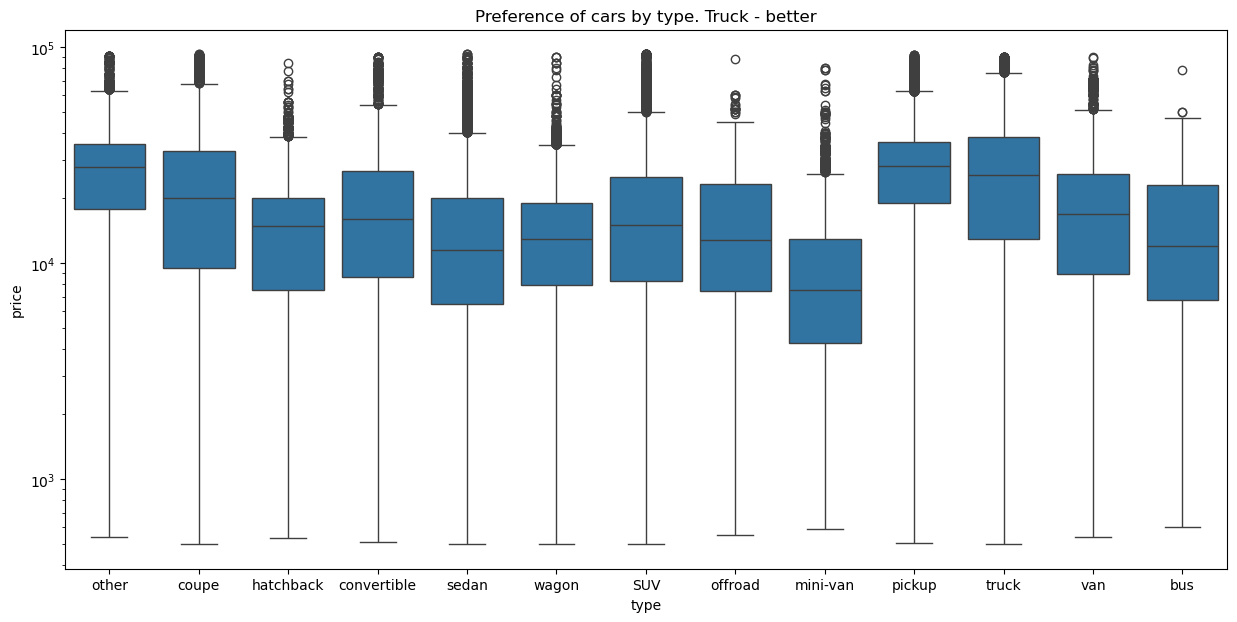

In [71]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(limited_price_df[['price', 'type']].sort_values('type', key=lambda v: v.apply(type_rank)), x="type", y="price")
ax.set_yscale("log")
ax.set_title('Preference of cars by type. Truck - better')

Text(0.5, 1.0, 'Preference of cars by fuel. Diesel - better and gas - much worse')

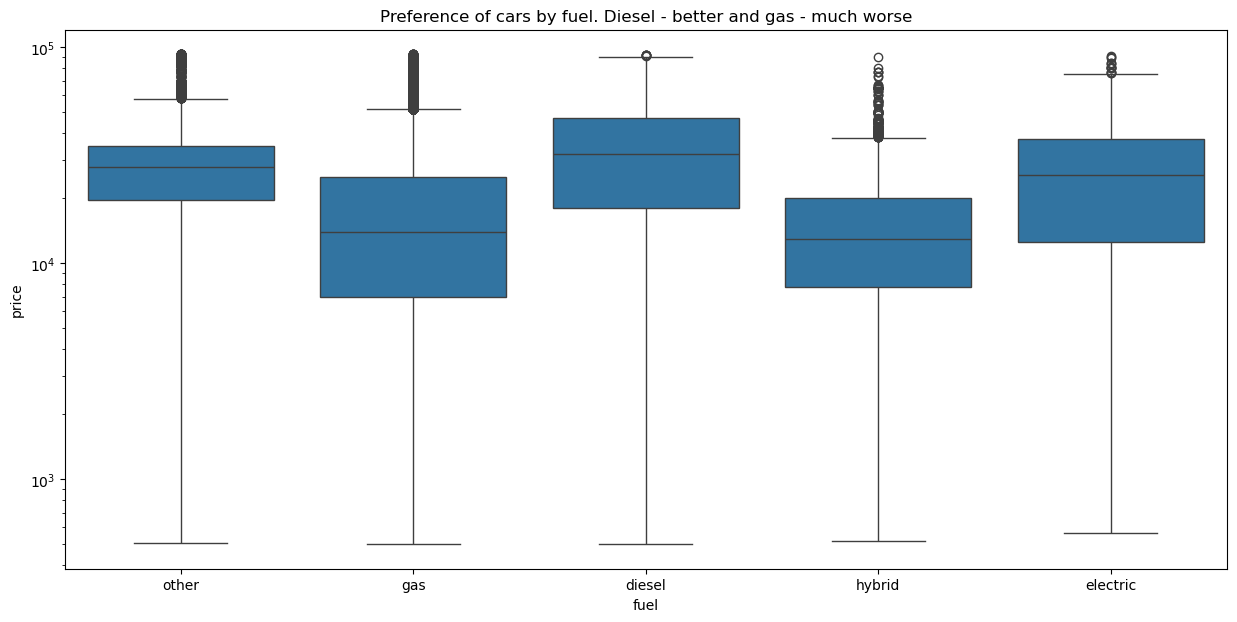

In [74]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(limited_price_df[['price', 'fuel']].sort_values('fuel', key=lambda v: v.apply(fuel_rank)), x="fuel", y="price")
ax.set_yscale("log")
ax.set_title('Preference of cars by fuel. Diesel - better and gas - much worse')

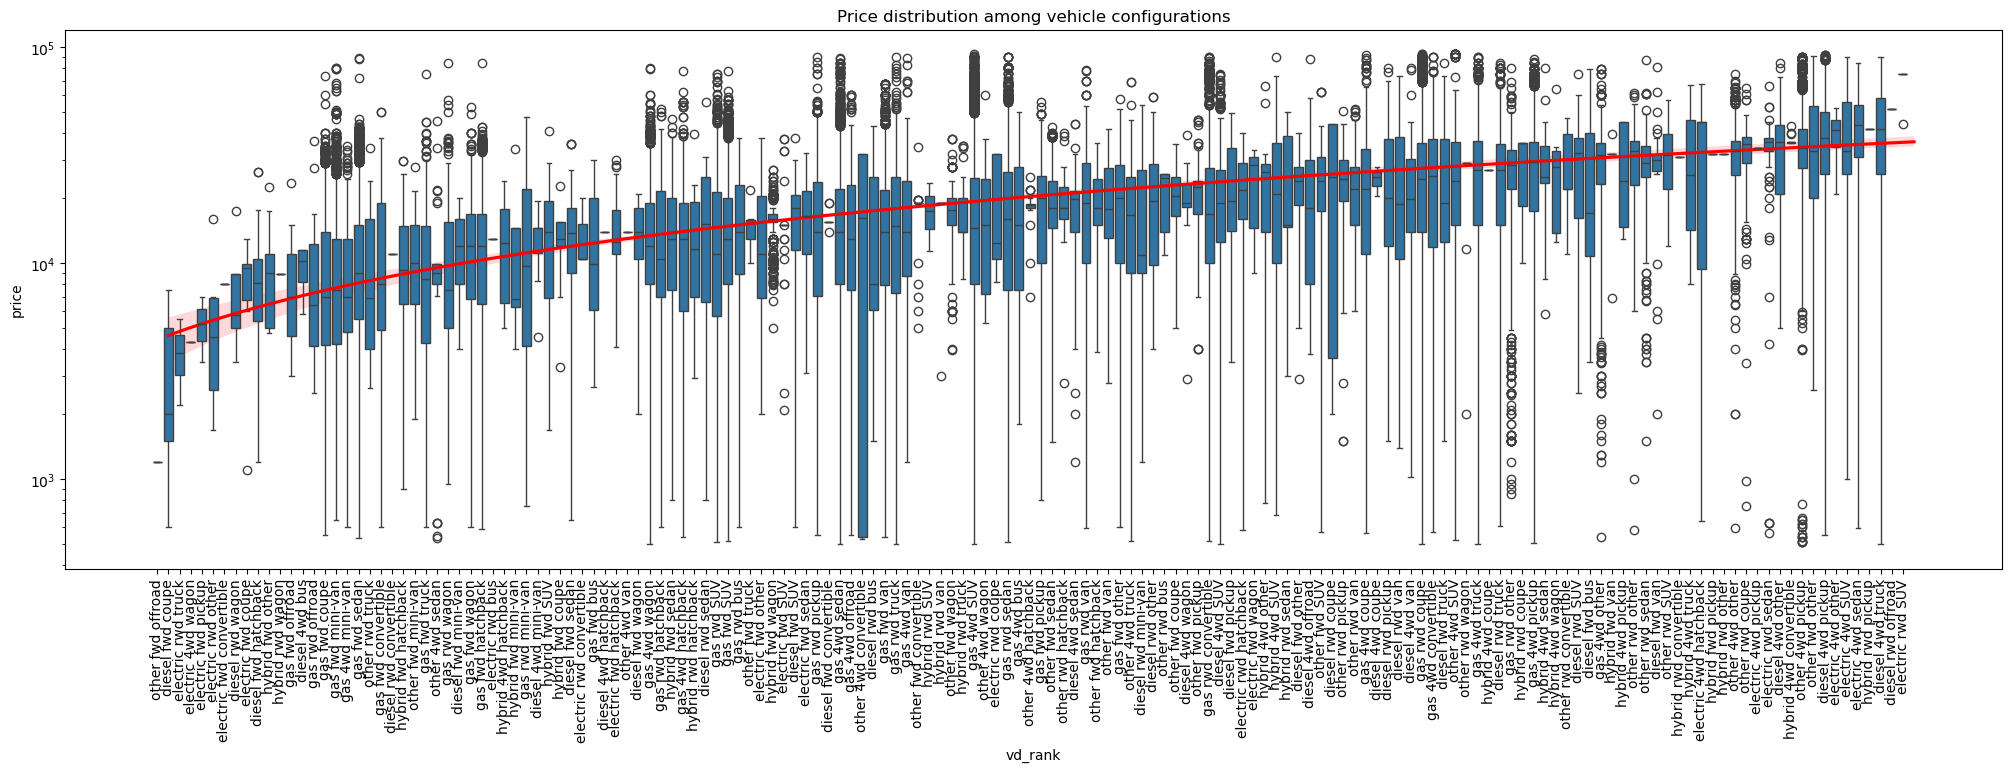

In [111]:
deployment_df = limited_price_df.copy()
deployment_df['vehicle_description'] = deployment_df['fuel'] + ' ' + deployment_df['drive'] + ' ' + deployment_df['type']
fig, ax = plt.subplots(figsize=(25,7))
ranking_df = deployment_df[['price', 'vehicle_description']].groupby('vehicle_description').mean().sort_values('price')
ranking_df['vd_rank'] = range(1, len(ranking_df) + 1)
plot_df = deployment_df[['price', 'vehicle_description']].sort_values('vehicle_description', key=lambda v: v.apply(lambda x: 0 if str(x) == 'nan' else ranking_df.loc[x].price))
ax_sub_box = sns.boxplot(plot_df, x="vehicle_description", y="price", ax=ax)
ax_sub_box.set_yscale("log")
ax_sub_box.set_title('Price distribution among vehicle configurations')
ax_sub_box.tick_params(axis='x', rotation=90)
sns.regplot(ranking_df, x="vd_rank", y="price", ax=ax, scatter=False, color='red')
plt.savefig('images/prediction_chart.png', bbox_inches='tight')